In [1]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is 

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
def get_qas(df,leave_id_out=True):
  """
  Cleans dataframes for later usage

    Args:
        df (DataFrame): The given DataFrame.
        leave_id_out (bool): Boolean switch for the id column.

    Returns:
        DataFrame: the cleaned DataFrame.
  """
  answers = df[df['ParentId'].notna()]
  questions = df[df['ParentId'].isna()]

  # drop unnecessary columns
  q = questions.drop(columns=['ParentId','PostTypeId','OwnerUserId','CommentCount','ContentLicense','CreationDate','LastActivityDate','ViewCount'])
  a = answers.drop(columns=['PostTypeId','OwnerUserId','CommentCount','ContentLicense','Title','Tags','AnswerCount','ViewCount','AcceptedAnswerId','CreationDate','LastActivityDate'])

  # merge
  merged = pd.merge(q, a, left_on='Id', right_on='ParentId', suffixes=('_question', '_answer'))
  merged = merged[['Id_question', 'Body_question', 'Body_answer', 'Score_answer']]

  merged.columns = [ 'question_id','question', 'answer', 'score']

  if leave_id_out:
    merged = merged.drop(columns=['question_id'])

  return merged

def normalize_scores(df,leave_min_max_out=True):
  """
  Normalizes scores based on the highest scored answer per question.

    Args:
        df (DataFrame): The given DataFrame.
        leave_min_max_out (bool): Boolean switch for the max_score column.

    Returns:
        DataFrame: the normalized DataFrame.
  """
  # max_score and min_score by question
  df['max_score'] = df.groupby('question')['score'].transform('max')
  df['min_score'] = df.groupby('question')['score'].transform('min')

  # normalize, offset by min to guarantee the value being between 0 and 1
  df['normalized_score'] = (df['score'] - df['min_score']) / (df['max_score'] - df['min_score'])

  if leave_min_max_out:
    df = df.drop(columns=['max_score','score','min_score'])
    df.rename(columns={'normalized_score':'score'},inplace=True)

  return df

def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["question"],examples['answer'], truncation=True, padding="max_length", max_length=256)

    # Change this to real number
    examples["label"] = float(label)
    return examples

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Compute accuracy
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

In [4]:
# using latin SE here
df = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/data/parsed/latin.csv?raw=True')

debug_mode = False

latin = get_qas(df)

if debug_mode:
  latin = normalize_scores(latin,False)
  latin = latin[latin['normalized_score'].notna()]

else:
  latin = normalize_scores(latin)
  latin = latin[latin['score'].notna()]

# kb 4000 droppolt row
latin

,question,answer,score
0,I was taught that one can use the '-que' suffi...,"The way I was taught was that, as a general ru...",1.000000
1,I was taught that one can use the '-que' suffi...,"In Ecclesiastical Latin ""-que"" would be used i...",0.309524
2,I was taught that one can use the '-que' suffi...,"Both et and -que can often translate ""and"". Th...",0.214286
3,I was taught that one can use the '-que' suffi...,James Kingsbery's answer is exactly correct. I...,0.119048
4,I was taught that one can use the '-que' suffi...,The que suffix has a usage example with moment...,0.000000
...,...,...,...
9327,"So, I'm a PhD student working on the history o...","I understand ""ut quotiens sit integer complexu...",1.000000
9328,"So, I'm a PhD student working on the history o...",I would advocate for a freer translation: I th...,0.000000
9330,"In a previous question of mine, What diphthong...","It isn’t traditionally used in normal writing,...",1.000000
9331,"In a previous question of mine, What diphthong...","Most of them don't need to be marked, since th...",0.000000


In [5]:
BASE_MODEL = "distilbert/distilbert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#se as in StackExchange
se = Dataset.from_pandas(latin)
train_test_split = se.train_test_split(test_size=0.2, seed=42)

se = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

for split in se:
    se[split] = se[split].map(preprocess_function, remove_columns=["score",'__index_level_0__'])

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

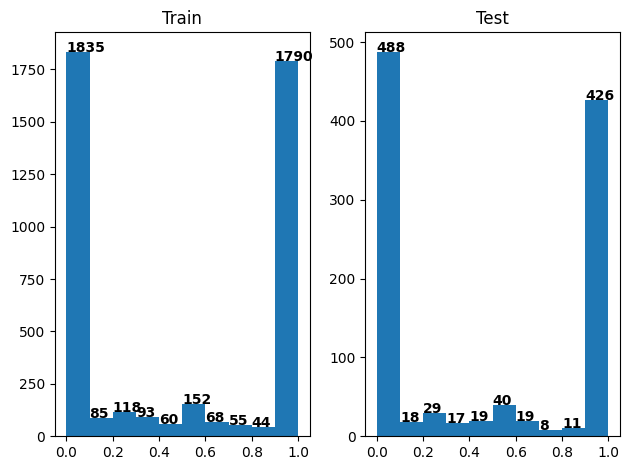

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Test");
train_distributions = axs[0].hist(se['train']["label"], bins=10)
test_distributions = axs[1].hist(se['test']["label"], bins=10)

for distributions, ax in zip([train_distributions, test_distributions], axs):
    for j in range(10):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [9]:
training_args = TrainingArguments(
    output_dir="../models/distilbert-qas-1",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [10]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [11]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=se["train"],
    eval_dataset=se["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,No log,0.219405,0.219405,0.446935,-0.009457,0.597209
2,0.217900,0.205256,0.205256,0.426902,0.055642,0.670698
3,0.217900,0.223878,0.223878,0.418700,-0.030036,0.637209
4,0.144300,0.311057,0.311057,0.450610,-0.431138,0.569302
5,0.144300,0.304326,0.304326,0.432836,-0.400167,0.594419
6,0.049100,0.311221,0.311221,0.435505,-0.431893,0.587907
7,0.049100,0.311335,0.311335,0.430773,-0.432415,0.598140
8,0.022600,0.329403,0.329403,0.442936,-0.515545,0.578605
9,0.022600,0.318739,0.318739,0.435975,-0.466482,0.597209
10,0.014800,0.305769,0.305769,0.430560,-0.406806,0.604651


TrainOutput(global_step=5380, training_loss=0.04556743221212054, metrics={'train_runtime': 2534.4426, 'train_samples_per_second': 33.933, 'train_steps_per_second': 2.123, 'total_flos': 5695996560384000.0, 'train_loss': 0.04556743221212054, 'epoch': 20.0})

In [13]:
trainer.eval_dataset=se["test"]
trainer.evaluate()

{'eval_loss': 0.20525573194026947,
 'eval_mse': 0.20525573194026947,
 'eval_mae': 0.42690184712409973,
 'eval_r2': 0.05564179020289994,
 'eval_accuracy': 0.6706976744186046,
 'eval_runtime': 9.5532,
 'eval_samples_per_second': 112.528,
 'eval_steps_per_second': 7.118,
 'epoch': 20.0}